[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ranggakd/steganography/blob/main/Exploring_Steganography_In_The_Wild_Part_1.ipynb)
[![Open Medium](https://img.shields.io/badge/-Open_Medium_Story-black?logo=medium)](https://medium.com/@ranggakd/exploring-steganography-in-the-wild-part-1-ea48e10ca607)
[![Open Dev](https://img.shields.io/badge/-Open_DEV_Post-black?logo=dev.to)](https://dev.to/ranggakd/exploring-steganography-in-the-wild-part-1-5hll)

This notebook is Google Colab compatible. Feel free to edit several parts so you could run them on your local device. More explanation available on Medium and DEV.

In [1]:
#@markdown *Last running requirement version*

!python -V
!pip freeze | grep -w 'numpy\|matplotlib\|Pillow\|scikit-learn'

Python 3.10.12
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.9
numpy==1.23.5
Pillow==9.4.0
scikit-learn==1.2.2


# 1️⃣Introduction

Steganography is the practice of concealing a message within another message or a physical object [[1]](https://en.wikipedia.org/wiki/Steganography), in this case is image. There are two images in general: a cover image and an hidden image. The idea is to concealing hidden image within the lowest bits of cover image. This spesific practice is called LSB or Least-Significant Bits.

These two images we reference are raster graphic digital images, which are basically a dot matrix data structure representing a grid of pixels. When working with binary codes, we have more significant bits and less significant bits, as you can see in the image below.

![8 bit binary digit](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/bit.png)

The __leftmost bit__ is __the most significant bit__. If we change the leftmost bit it will have a large impact on the final value. For example, if we change the leftmost bit from 1 to 0 (11111111 to 01111111) it will change the decimal value from 255 to 127.

On the other hand, the __rightmost bit__ is __the less significant bit__. If we change the rightmost bit it will have less impact on the final value. For example, if we change the leftmost bit from 1 to 0 (11111111 to 11111110) it will change the decimal value from 255 to 254. Note that the rightmost bit will change only 1 in a range of 256 (it represents less than 1%).

So, if we change the rightmost bits it will have a small visual impact on the final image. This is the steganography key to hide an image inside another. Change the less significant bits from an image and include the most significant bits from the other image [[2]](https://towardsdatascience.com/steganography-hiding-an-image-inside-another-77ca66b2acb1).

![pixel](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/pixel.png)

In [2]:
#@markdown Import libraries {run: 'auto'}

import os
import imghdr
import numpy as np
from PIL import Image
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from google.colab import files
%matplotlib inline

Saving attack titan.jpeg to attack titan.jpeg
Saving eren.jpeg to eren.jpeg
User uploaded file "attack titan.jpeg" with length 244624 bytes
User uploaded file "eren.jpeg" with length 80138 bytes


attack titan.jpeg size: (1480, 2516, 3)
eren.jpeg size: (675, 1200, 3)


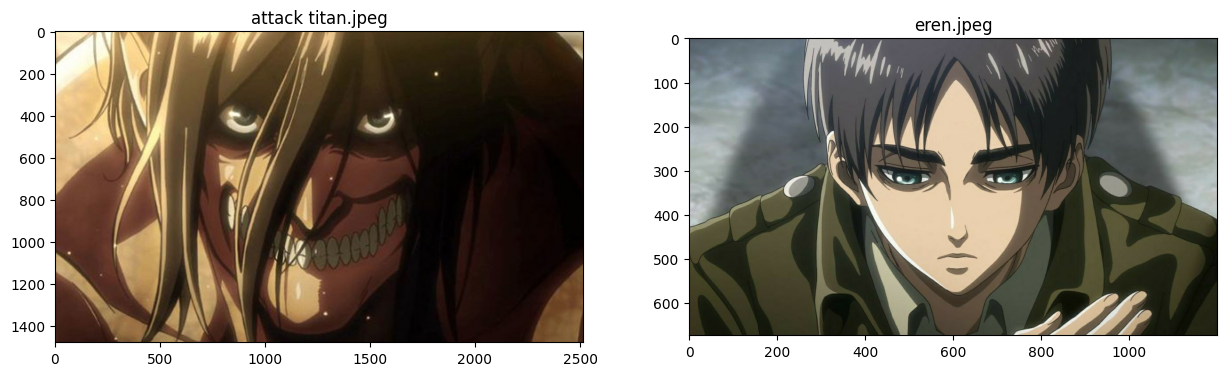

In [3]:
#@title Upload 2 custom images
#@markdown We're gonna cover one image over another. Make sure **one image which will be
#@markdown hidden** has at **most the same size** as it **cover image**

uploaded = files.upload()
image_filenames = []
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  image_filenames.append(fn)
assert len(image_filenames)==2, f"Choose 2 files at once"
print('\n')
_, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    image = plt.imread(image_filenames[i])
    print(f"{image_filenames[i]} size: {image.shape}")
    ax[i].imshow(image)
    ax[i].set_title(image_filenames[i])

In [4]:
#@title Choose which one is the cover {run: 'auto'}
#@markdown One for the **cover image**, other as the **hidden image** e.g. `attack titan.jpg`

COVER_IMAGE = 'attack titan.jpeg' #@param {type: "string"}
HIDDEN_IMAGE = 'eren.jpeg' #@param {type: "string"}

assert os.path.isfile(COVER_IMAGE), f"There's no file named {COVER_IMAGE}"
assert os.path.isfile(HIDDEN_IMAGE), f"There's no file named {HIDDEN_IMAGE}"
assert COVER_IMAGE != HIDDEN_IMAGE, f"{COVER_IMAGE} and {HIDDEN_IMAGE} cannot be the same image"
ci_img = plt.imread(COVER_IMAGE).shape
hi_img = plt.imread(HIDDEN_IMAGE).shape
assert ci_img[0] >= hi_img[0] or ci_img[1] >= hi_img[1], \
    f"There's at least one dimension of hidden image is greater than cover image. Try the other way around."
print(f'{HIDDEN_IMAGE} could be hidden inside {COVER_IMAGE} 😉👌')

eren.jpeg could be hidden inside attack titan.jpeg 😉👌


![left half bits](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/lhb.png)

In [5]:
#@markdown Mapping **binary values** with their corresponding **left half bits values** (*extract the left half bits values of cover image from merged image*)

PIXEL_LIMIT = 256
ZERO_BINARY = '0000'
d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[0:4]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({i: new_val})

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='\t➡\t')
    print(f'{v}\t{np.binary_repr(v).zfill(8)}')

0	00000000	➡	0	00000000
1	00000001	➡	0	00000000
2	00000010	➡	0	00000000
3	00000011	➡	0	00000000
4	00000100	➡	0	00000000
5	00000101	➡	0	00000000
6	00000110	➡	0	00000000
7	00000111	➡	0	00000000
8	00001000	➡	0	00000000
9	00001001	➡	0	00000000
10	00001010	➡	0	00000000
11	00001011	➡	0	00000000
12	00001100	➡	0	00000000
13	00001101	➡	0	00000000
14	00001110	➡	0	00000000
15	00001111	➡	0	00000000
16	00010000	➡	16	00010000
17	00010001	➡	16	00010000
18	00010010	➡	16	00010000
19	00010011	➡	16	00010000
20	00010100	➡	16	00010000
21	00010101	➡	16	00010000
22	00010110	➡	16	00010000
23	00010111	➡	16	00010000
24	00011000	➡	16	00010000
25	00011001	➡	16	00010000
26	00011010	➡	16	00010000
27	00011011	➡	16	00010000
28	00011100	➡	16	00010000
29	00011101	➡	16	00010000
30	00011110	➡	16	00010000
31	00011111	➡	16	00010000
32	00100000	➡	32	00100000
33	00100001	➡	32	00100000
34	00100010	➡	32	00100000
35	00100011	➡	32	00100000
36	00100100	➡	32	00100000
37	00100101	➡	32	00100000
38	00100110	➡	32	00100000
39	00100111	

![right half bits](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/rhb.png)

In [6]:
#@markdown Mapping **binary values** with their corresponding **right half bits values** (*extract the left half bits values of hidden image from merged image*)

d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[4:8]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({i: new_val})

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='\t➡\t')
    print(f'{v}\t{np.binary_repr(v).zfill(8)}')

0	00000000	➡	0	00000000
1	00000001	➡	16	00010000
2	00000010	➡	32	00100000
3	00000011	➡	48	00110000
4	00000100	➡	64	01000000
5	00000101	➡	80	01010000
6	00000110	➡	96	01100000
7	00000111	➡	112	01110000
8	00001000	➡	128	10000000
9	00001001	➡	144	10010000
10	00001010	➡	160	10100000
11	00001011	➡	176	10110000
12	00001100	➡	192	11000000
13	00001101	➡	208	11010000
14	00001110	➡	224	11100000
15	00001111	➡	240	11110000
16	00010000	➡	0	00000000
17	00010001	➡	16	00010000
18	00010010	➡	32	00100000
19	00010011	➡	48	00110000
20	00010100	➡	64	01000000
21	00010101	➡	80	01010000
22	00010110	➡	96	01100000
23	00010111	➡	112	01110000
24	00011000	➡	128	10000000
25	00011001	➡	144	10010000
26	00011010	➡	160	10100000
27	00011011	➡	176	10110000
28	00011100	➡	192	11000000
29	00011101	➡	208	11010000
30	00011110	➡	224	11100000
31	00011111	➡	240	11110000
32	00100000	➡	0	00000000
33	00100001	➡	16	00010000
34	00100010	➡	32	00100000
35	00100011	➡	48	00110000
36	00100100	➡	64	01000000
37	00100101	➡	80	01010000
38	0010

![merged bits](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/mb.png)

In [7]:
#@markdown Mapping **binary values** with their corresponding **whole bits values** (*construct the whole bits values of merged image from the 2 left half bits values of cover and hidden images*)

PIXEL_LIMIT = 256
ZERO_BINARY = '0000'
d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[0:4]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({i: new_val})
e = dict(d)
print('Only show the first 510 rows')
for k, v in d.items():
    if k == 2: break
    for ke, ve in e.items():
        print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='\t:\t')
        print(f'{v}\t{np.binary_repr(v).zfill(8)}', end='\t+\t')
        print(f'{ke}\t{np.binary_repr(ke).zfill(8)}', end='\t:\t')
        print(f'{ve}\t{np.binary_repr(ve).zfill(8)}', end='\t=\t')
        left_half_bits_first = np.binary_repr(k).zfill(8)[0:4]
        left_half_bits_second = np.binary_repr(ke).zfill(8)[0:4]
        merged_bits = int(left_half_bits_first + left_half_bits_second, 2)
        print(f'{merged_bits}\t{np.binary_repr(merged_bits).zfill(8)}')


Only show the first 510 rows
0	00000000	:	0	00000000	+	0	00000000	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	1	00000001	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	2	00000010	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	3	00000011	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	4	00000100	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	5	00000101	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	6	00000110	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	7	00000111	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	8	00001000	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	9	00001001	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	10	00001010	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	11	00001011	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	12	00001100	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	13	00001101	:	0	00000000	=	0	00000000
0	00000000	:	0	00000000	+	14	00001110	:	0	00000000	=	0	00000000
0	00000000	:	0	000000

![reconstruction](https://raw.githubusercontent.com/ranggakd/steganography/main/assets/recon.png)

In [8]:
#@markdown Mapping **binary values** with their possible **right half bits values** (*construct the right half bits values of unmerged left half bits image*)

d = {}
for i in range(PIXEL_LIMIT):
    four_bits = np.binary_repr(i).zfill(8)[0:4]
    new_val = int(four_bits + ZERO_BINARY, 2)
    d.update({new_val: [i]}) if d.get(new_val) is None else d[new_val].append(i)

for k, v in d.items():
    print(f'{k}\t{np.binary_repr(k).zfill(8)}', end='')
    for i, p in enumerate(v):
        if i == 0:
            prefix = '\t➡\t'
        else:
            prefix = '\t\t\t➡\t'
        print(f'{prefix}{p}\t{np.binary_repr(p).zfill(8)}')

0	00000000	➡	0	00000000
			➡	1	00000001
			➡	2	00000010
			➡	3	00000011
			➡	4	00000100
			➡	5	00000101
			➡	6	00000110
			➡	7	00000111
			➡	8	00001000
			➡	9	00001001
			➡	10	00001010
			➡	11	00001011
			➡	12	00001100
			➡	13	00001101
			➡	14	00001110
			➡	15	00001111
16	00010000	➡	16	00010000
			➡	17	00010001
			➡	18	00010010
			➡	19	00010011
			➡	20	00010100
			➡	21	00010101
			➡	22	00010110
			➡	23	00010111
			➡	24	00011000
			➡	25	00011001
			➡	26	00011010
			➡	27	00011011
			➡	28	00011100
			➡	29	00011101
			➡	30	00011110
			➡	31	00011111
32	00100000	➡	32	00100000
			➡	33	00100001
			➡	34	00100010
			➡	35	00100011
			➡	36	00100100
			➡	37	00100101
			➡	38	00100110
			➡	39	00100111
			➡	40	00101000
			➡	41	00101001
			➡	42	00101010
			➡	43	00101011
			➡	44	00101100
			➡	45	00101101
			➡	46	00101110
			➡	47	00101111
48	00110000	➡	48	00110000
			➡	49	00110001
			➡	50	00110010
			➡	51	00110011
			➡	52	00110100
			➡	53	00110101
			➡	54	00110110
			➡	55	00110111
			➡	56	00111000
			➡	5

In [9]:
#@markdown Helper function definition

def get_bits_dict(start: int, end: int, recon: bool = False) -> Dict[int, int]:
    '''Generate the bits lookup dictionary.'''
    bits_dict = {}
    s = slice(start, end)
    for i in range(256):
        four_bits = np.binary_repr(i).zfill(8)[s]
        new_val = int(four_bits + '0000', 2)
        if not recon:
            bits_dict.update({i: new_val})
        else:
            if bits_dict.get(new_val) is None:
                bits_dict.update({new_val: [i]})
            else:
                bits_dict[new_val].append(i)
    return bits_dict

def get_merged_bits_array() -> np.ndarray:
    '''Generate the merged bits lookup 2D numpy array.'''
    lookup = np.zeros((256, 256), dtype='uint8')
    for i in range(256):
        for j in range(256):
            left_half_bits_cover = np.binary_repr(i).zfill(8)[:4]
            left_half_bits_hidden = np.binary_repr(j).zfill(8)[:4]
            merged_bits = int(left_half_bits_cover + left_half_bits_hidden, 2)
            lookup[i, j] = merged_bits
    return lookup

def dict_to_nparray(d: dict) -> np.ndarray:
    '''Convert dictionary into numpy array.'''
    n = len(d)
    arr = np.zeros(n, dtype='uint8')
    for k,v in d.items():
        arr[k] = v
    return arr

def dict_to_2darray(d: dict) -> np.ndarray:
    '''Convert dictionary into 2D numpy array.'''
    arr = np.zeros((256, 16), dtype='uint8')
    for k, vlist in d.items():
        arr[k, :len(vlist)] = vlist
    return arr

lhb = dict_to_nparray(get_bits_dict(0, 4))          # Left half bits array lookup
rhb = dict_to_nparray(get_bits_dict(4, 8))          # Right half bits array lookup
mb = get_merged_bits_array()                        # Merged bits 2D array lookup
rrhb = dict_to_2darray(get_bits_dict(0, 4, True))   # Reconstruction right half bits 2D array lookup

In [10]:
#@markdown Steganograph class definition

class Steganograph:
    '''
    A simple exploratory class to create a steganograph based on 2 images.

    Attributes
    ----------
    ispng : bool
        True if both the cover and hidden images are in PNG format; otherwise, False.
    original_cover_image : numpy array
        The original cover image.
    original_hidden_image : numpy array
        The original hidden image.
    left_half_bits_hidden_image : numpy array, default None
        The left half-bits of the hidden image.
    merged_image : numpy array, default None
        The merged image, also known as the steganograph.
    unmerged_left_half_bits_cover_image : numpy array, default None
        The cover image with its left half-bits unmerged.
    unmerged_left_half_bits_hidden_image : numpy array, default None
        The hidden image with its left half-bits unmerged.
    reconstructed_cover_image : numpy array, default None
        The reconstructed cover image.
    reconstructed_hidden_image : numpy array, default None
        The reconstructed hidden image.

    Methods
    -------
    encode(pos: str = 'upper_left'):
        Create a simple steganograph.
    decode(pos: str = 'upper_left'):
        Break down a simple steganograph.
    encode_decode(pos: str = 'upper_left'):
        Create a simple steganograph then break it down.
    reconstruct():
        Reconstruct unmerged left half-bits images by manipulating their right half-bits.
    encode_decode_recon(pos: str = 'upper_left'):
        Create a simple steganograph, break it down, and then reconstruct the right half-bits.
    is_two_images_identical(opt: int = 0) -> bool:
        Check whether two specified images are identical.
    save_image(opt: int = 0):
        Save an image from steganograph instance.
    plot_original():
        Plot original images.
    plot_left_half_bits():
        Plot left half bits hidden image.
    plot_merged_image():
        Plot merged image.
    plot_unmerged_left_half_bits():
        Plot the RGB, red, green, and blue channels of the unmerged left half-bits images.
    plot_recon():
        Plot the RGB, red, green, and blue channels of the reconstructed images.
    '''
    __lhb_lookup = lhb      # Left half bits array lookup
    __rhb_lookup = rhb      # Right half bits array lookup
    __mb_lookup = mb        # Merged bits 2D array lookup
    __rrhb_lookup = rrhb    # Reconstruction right half bits 2D array lookup
    # Format image extension tuple
    __format = ('jpeg', 'png')
    # Channel image tuple
    __rgb = ('RGB', 'Red', 'Green', 'Blue')
    # Position of hidden image underneath cover image tuple
    __pos = ('upper_left', 'upper_right', 'lower_left', 'lower_right')

    def __init__(self, cover_image_filepath: str, hidden_image_filepath: str):
        '''
        Initialize the steganograph instance using the file paths of the cover and hidden images.
        The cover and hidden images must have the same file format extension.

        Parameters
        ----------
        cover_image_filepath : str
            The file path of the cover image to read (supports only JPEG or PNG formats).
        hidden_image_filepath : str
            The file path of the hidden image to read (supports only JPEG or PNG formats).
        '''
        format_ci = imghdr.what(cover_image_filepath).lower()
        format_hi = imghdr.what(hidden_image_filepath).lower()
        if not self.validate_image_formats(format_ci, format_hi):
            raise TypeError(
                f'Either {cover_image_filepath!r} or {hidden_image_filepath!r}'
                f' is one of {self.__format!r}'
                )
        if not self.have_same_formats(format_ci, format_hi):
            raise TypeError(
                f'The cover ({format_ci!r}) and hidden ({format_hi!r}) images '
                'must have the same file format extension'
            )
        self.ispng = True if format_ci == self.__format[-1] else False
        self.original_cover_image = plt.imread(cover_image_filepath)
        self.original_hidden_image = plt.imread(hidden_image_filepath)
        self.read_and_adjust_images()
        self.left_half_bits_hidden_image = None
        self.merged_image = None
        self.unmerged_left_half_bits_cover_image = None
        self.unmerged_left_half_bits_hidden_image = None
        self.reconstructed_cover_image = None
        self.reconstructed_hidden_image = None

    def __repr__(self):
        '''Return all instance attribute values at current state.'''
        output = f'Steganograph:\n'
        for (attr, val) in vars(self).items():
            if val is None or isinstance(val, bool):
                output += f'{attr}: {val}\n'
            else:
                output += f'{attr}: {val.shape} {val.dtype}\n'
        return output

    def read_and_adjust_images(self):
        '''Read and adjust the cover and hidden images.'''
        if self.ispng:
            if self.original_cover_image.shape[-1] != 3:
                #ignore the A channel for now
                self.original_cover_image = np.round(self.original_cover_image[:,:,:-1]*255)
            else:
                self.original_cover_image = np.round(self.original_cover_image*255)
            if self.original_hidden_image.shape[-1] != 3:
                #ignore the A channel for now
                self.original_hidden_image = np.round(self.original_hidden_image[:,:,:-1]*255)
            else:
                self.original_hidden_image = np.round(self.original_hidden_image*255)
            self.original_cover_image = self.original_cover_image.astype('uint8')
            self.original_hidden_image = self.original_hidden_image.astype('uint8')

    def have_same_formats(self, format_ci: str, format_hi: str) -> bool:
        '''Check whether the images have the same file formats.'''
        return format_ci == format_hi

    def validate_image_formats(self, format_ci: str, format_hi: str) -> bool:
        '''Validating image formats with our current available supported formats.'''
        return format_ci in self.__format and format_hi in self.__format

    def get_left_half_bits(self, img_arr: np.ndarray) -> np.ndarray:
        '''Construct a left half bits only image of an image.'''
        return self.__lhb_lookup[img_arr]

    def get_right_half_bits(self, img_arr: np.ndarray) -> np.ndarray:
        '''Construct a right half bits only image of an image.'''
        return self.__rhb_lookup[img_arr]

    def get_slicing(self, large_shape: tuple, small_shape: tuple, pos: str) -> tuple:
        '''Get the slicing range based on the given position.'''
        row_max, col_max, _ = large_shape
        row_threshold, col_threshold, _ = small_shape
        if pos == self.__pos[0]:
            return np.s_[0:row_threshold, 0:col_threshold, :]
        elif pos == self.__pos[1]:
            return np.s_[0:row_threshold, col_max-col_threshold:col_max, :]
        elif pos == self.__pos[2]:
            return np.s_[row_max-row_threshold:row_max, 0:col_threshold, :]
        elif pos == self.__pos[3]:
            return np.s_[row_max-row_threshold:row_max, col_max-col_threshold:col_max, :]
        else:
            raise ValueError(f"Invalid position: {pos}")

    def merge_two_half_bits(self, pos: str):
        '''Merge two half bits images.'''
        self.merged_image = self.original_cover_image.copy()
        pos_slice = self.get_slicing(
            self.merged_image.shape,
            self.left_half_bits_hidden_image.shape,
            pos
            )
        # assign the left half bits hidden image into subarray of cover image
        # separate the color channels
        for channel in range(3):
            self.merged_image[pos_slice][..., channel] = self.__mb_lookup[
                self.merged_image[pos_slice][..., channel],
                self.left_half_bits_hidden_image[..., channel]
            ]
        self.merged_image = self.merged_image.astype('uint8')

    def reconstruct_right_half_bits(self, im_arr: np.ndarray, seed: int = 1999) -> np.ndarray:
        '''Reconstruct the right half bits of unmerged image with random sampling.'''
        np.random.seed(seed)
        shape = im_arr.shape
        flat_im_arr = im_arr.ravel()
        # generate random indices to simulate random.choice of random sampling
        random_indices = np.random.randint(0,
                                           self.__rrhb_lookup.shape[1],
                                           size=flat_im_arr.shape
                                           )
        # reconstruct image
        reconstructed_flat = self.__rrhb_lookup[flat_im_arr, random_indices]
        return reconstructed_flat.reshape(shape).astype('uint8')

    def unmerge_two_half_bits(self, pos: str):
        '''
        Unmerge merged image into a separate two half bits images
        (unmerged cover and hidden images).
        '''
        pos_slice = self.get_slicing(
            self.merged_image.shape,
            self.left_half_bits_hidden_image.shape,
            pos
            )
        # extract left and right half bits directly
        self.unmerged_left_half_bits_cover_image = self.get_left_half_bits(self.merged_image)
        self.unmerged_left_half_bits_hidden_image = self.get_right_half_bits(
            self.merged_image)[pos_slice]

    def encode(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image
            is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        if pos not in self.__pos:
            raise ValueError(f'Expected {pos!r} is one of {self.__pos!r}')
        self.left_half_bits_hidden_image = self.get_left_half_bits(self.original_hidden_image)
        self.merge_two_half_bits(pos)

    def decode(self, pos: str = 'upper_left'):
        '''
        Break down a simple steganograph.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image
            is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        if self.merged_image is None:
            raise TypeError(
                f'Merged image cannot be None. Expected to run encode() first'
                )
        if pos not in self.__pos:
            raise ValueError(f'Expected {pos!r} is one of {self.__pos!r}')
        self.unmerge_two_half_bits(pos)

    def encode_decode(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph then break it down.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image
            is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        self.encode(pos)
        self.decode(pos)

    def reconstruct(self):
        '''Reconstruct unmerged left half bits images by manipulation their right half bits.'''
        if self.unmerged_left_half_bits_cover_image is None \
            or self.unmerged_left_half_bits_hidden_image is None:
            raise TypeError(
                f'Either unmerged left half bits cover or hidden image is None. '
                'Expected to run decode() first'
                )
        self.reconstructed_cover_image = self.reconstruct_right_half_bits(
            self.unmerged_left_half_bits_cover_image)
        self.reconstructed_hidden_image = self.reconstruct_right_half_bits(
            self.unmerged_left_half_bits_hidden_image)

    def encode_decode_recon(self, pos: str = 'upper_left'):
        '''
        Create a simple steganograph, break it down, then reconstruct the right half bits of them.

        Parameter
        ---------
        pos : str, default 'upper_left'
            the position where the hidden image is placed underneath the cover image
            is as follows: 'upper_left', 'upper_right', 'lower_left' and 'lower_right'
        '''
        self.encode_decode(pos)
        self.reconstruct()

    def error(self, img_arr1: np.ndarray, img_arr2: np.ndarray) -> Tuple[float, float]:
        '''Calculate two images differences by RMSE and MAE.'''
        rmse = mean_squared_error(img_arr1.ravel(), img_arr2.ravel(), squared=False)
        mae = mean_absolute_error(img_arr1.ravel(), img_arr2.ravel())
        return rmse, mae

    def check_option(self, opt: int) -> Tuple[np.ndarray, np.ndarray]:
        '''Switch-case dictionary like function to choose images option.'''
        return {
            # cover image
            0: lambda: (
                self.original_cover_image,
                self.unmerged_left_half_bits_cover_image
                ),
            1: lambda: (
                self.original_cover_image,
                self.reconstructed_cover_image
                ),
            2: lambda: (
                self.unmerged_left_half_bits_cover_image,
                self.reconstructed_cover_image
                ),
            3: lambda: (
                self.merged_image,
                self.original_cover_image
                ),
            4: lambda: (
                self.merged_image,
                self.unmerged_left_half_bits_cover_image
                ),
            5: lambda: (
                self.merged_image,
                self.reconstructed_cover_image
                ),
            # hidden image
            6: lambda: (
                self.original_hidden_image,
                self.unmerged_left_half_bits_hidden_image
                ),
            7: lambda: (
                self.original_hidden_image,
                self.reconstructed_hidden_image
                ),
            8: lambda: (
                self.unmerged_left_half_bits_hidden_image,
                self.reconstructed_hidden_image
                ),
            9: lambda: (
                self.left_half_bits_hidden_image,
                self.original_hidden_image
                ),
            10: lambda: (
                self.left_half_bits_hidden_image,
                self.unmerged_left_half_bits_hidden_image
                ),
            11: lambda: (
                self.left_half_bits_hidden_image,
                self.reconstructed_hidden_image
                )
        }.get(opt, lambda: None)()

    def is_two_images_identical(self, opt: int = 0) -> Tuple[bool, float, float]:
        '''
        Check whether certain image are as equal as other image.

        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
            11 : left half bits hidden image <-> reconstructed hidden image
        '''
        if opt < 0 or opt > 11:
            raise ValueError(f'Expected {opt!r} to be between 0 and 11 inclusively')
        img_arr1, img_arr2 = self.check_option(opt)
        if img_arr1 is None or img_arr2 is None:
            raise TypeError(f'Either one of two images is None')
        rmse, mae = self.error(img_arr1, img_arr2)
        if np.array_equal(img_arr1, img_arr2):
            return (True, rmse, mae)
        return (False, rmse, mae)

    def save_option(self, opt: int) -> Tuple[np.ndarray, str]:
        '''Switch-case dictionary like function to choose which image to save.'''
        return {
            # original images
            0: lambda: (
                self.original_cover_image,
                'Original Cover Image'
                ),
            1: lambda: (
                self.original_hidden_image,
                'Original Hidden Image'
                ),
            # left half bits image
            2: lambda: (
                self.left_half_bits_hidden_image,
                'Left Half Bits Hidden Image'
                ),
            # merged image
            3: lambda: (
                self.merged_image,
                'Merged Image'
                ),
            # unmerged left half bits images
            4: lambda: (
                self.unmerged_left_half_bits_cover_image,
                'Unmerged Left Half Bits Cover Image'
                ),
            5: lambda: (
                self.unmerged_left_half_bits_hidden_image,
                'Unmerged Left Half Bits Hidden Image'
                ),
            # reconstructed images
            6: lambda: (
                self.reconstructed_cover_image,
                'Reconstructed Cover Image'
                ),
            7: lambda: (
                self.reconstructed_hidden_image,
                'Reconstructed Hidden Image'
                )
        }.get(opt, lambda: None)()

    def save_image(self, opt: int = 0):
        '''
        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        '''
        if opt < 0 or opt > 7:
            raise ValueError(f'Expected {opt!r} to be between 0 and 7 inclusively')
        img_arr, filename = self.save_option(opt)
        if img_arr is None:
            raise TypeError(f'The images is None')
        img_obj = Image.fromarray(img_arr)
        if self.ispng:
            img_obj.save(f'{filename}.{self.__format[-1]}')
        img_obj.save(f'{filename}.{self.__format[0]}', quality=100, subsampling=0)

    def plot_images(self, kind: str, ci_arr: np.ndarray, hi_arr: np.ndarray):
        '''Plot RGB, red, green and blue channel of 2 images.'''
        im_arr_tuple = (ci_arr, hi_arr)
        _, ax = plt.subplots(len(im_arr_tuple), len(self.__rgb), figsize=(20, 7))
        for i, im in enumerate(im_arr_tuple):
            for j in range(len(self.__rgb)):
                if j == 0:
                    # RGB image
                    img = im
                else:
                    # red, green or blue only image
                    img = np.zeros(im.shape, dtype='uint8')
                    img[:,:,j-1] = im[:,:,j-1]
                image_kind = 'Cover' if i == 0 else 'Hidden'
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{self.__rgb[j]} of {kind} {image_kind} image')
        plt.tight_layout()

    def plot_image(self, kind: str, img_arr: np.ndarray):
        '''Plot RGB, red, green and blue channel of an image.'''
        _, ax = plt.subplots(1, len(self.__rgb), figsize=(20, 10))
        for j in range(len(self.__rgb)):
            if j == 0:
                # RGB image
                img = img_arr
            else:
                # red, green or blue only image
                img = np.zeros(img_arr.shape, dtype='uint8')
                img[:,:,j-1] = img_arr[:,:,j-1]
            ax[j].imshow(img)
            ax[j].set_title(f'{self.__rgb[j]} of {kind} image')
        plt.tight_layout()

    def plot_original(self):
        '''Plot original images.'''
        self.plot_images('Original', self.original_cover_image, self.original_hidden_image)

    def plot_left_half_bits(self):
        '''Plot left half bits hidden image.'''
        if self.left_half_bits_hidden_image is None:
            raise TypeError(
                f'Left half bits hidden image cannot be None. '
                'Expected to run encode() first'
                )
        self.plot_image('Left Half Bits Hidden', self.left_half_bits_hidden_image)

    def plot_merged_image(self):
        '''Plot merged image.'''
        if self.merged_image is None:
            raise TypeError(f'Merged image cannot be None. Expected to run encode() first')
        self.plot_image('Merged', self.merged_image)

    def plot_unmerged_left_half_bits(self):
        '''Plot RGB, red, green and blue channel of unmerged left half bits images.'''
        if self.unmerged_left_half_bits_cover_image is None \
            or self.unmerged_left_half_bits_hidden_image is None:
            raise TypeError(
                f'Either unmerged left half bits cover or hidden image is None. '
                'Expected to run decode() first'
                )
        self.plot_images(
            'Unmerged Left Half Bits',
            self.unmerged_left_half_bits_cover_image,
            self.unmerged_left_half_bits_hidden_image
            )

    def plot_recon(self):
        '''Plot RGB, red, green and blue channel of reconstructed images.'''
        if self.reconstructed_cover_image is None \
            and self.reconstructed_hidden_image is None:
            raise TypeError(
                f'Either reconstructed cover or hidden image is None. '
                'Expected to run reconstruct() first'
                )
        self.plot_images(
            'Reconstructed',
            self.reconstructed_cover_image,
            self.reconstructed_hidden_image
            )

In [11]:
#@title Steganograpah instantiation

sg = Steganograph(COVER_IMAGE, HIDDEN_IMAGE)
sg

Steganograph:
ispng: False
original_cover_image: (1480, 2516, 3) uint8
original_hidden_image: (675, 1200, 3) uint8
left_half_bits_hidden_image: None
merged_image: None
unmerged_left_half_bits_cover_image: None
unmerged_left_half_bits_hidden_image: None
reconstructed_cover_image: None
reconstructed_hidden_image: None

In [12]:
#@markdown What to explore from the instance

print(sg.__doc__)


    A simple exploratory class to create a steganograph based on 2 images.

    Attributes
    ----------
    ispng : bool
        True if both the cover and hidden images are in PNG format; otherwise, False.
    original_cover_image : numpy array
        The original cover image.
    original_hidden_image : numpy array
        The original hidden image.
    left_half_bits_hidden_image : numpy array, default None
        The left half-bits of the hidden image.
    merged_image : numpy array, default None
        The merged image, also known as the steganograph.
    unmerged_left_half_bits_cover_image : numpy array, default None
        The cover image with its left half-bits unmerged.
    unmerged_left_half_bits_hidden_image : numpy array, default None
        The hidden image with its left half-bits unmerged.
    reconstructed_cover_image : numpy array, default None
        The reconstructed cover image.
    reconstructed_hidden_image : numpy array, default None
        The reconstru

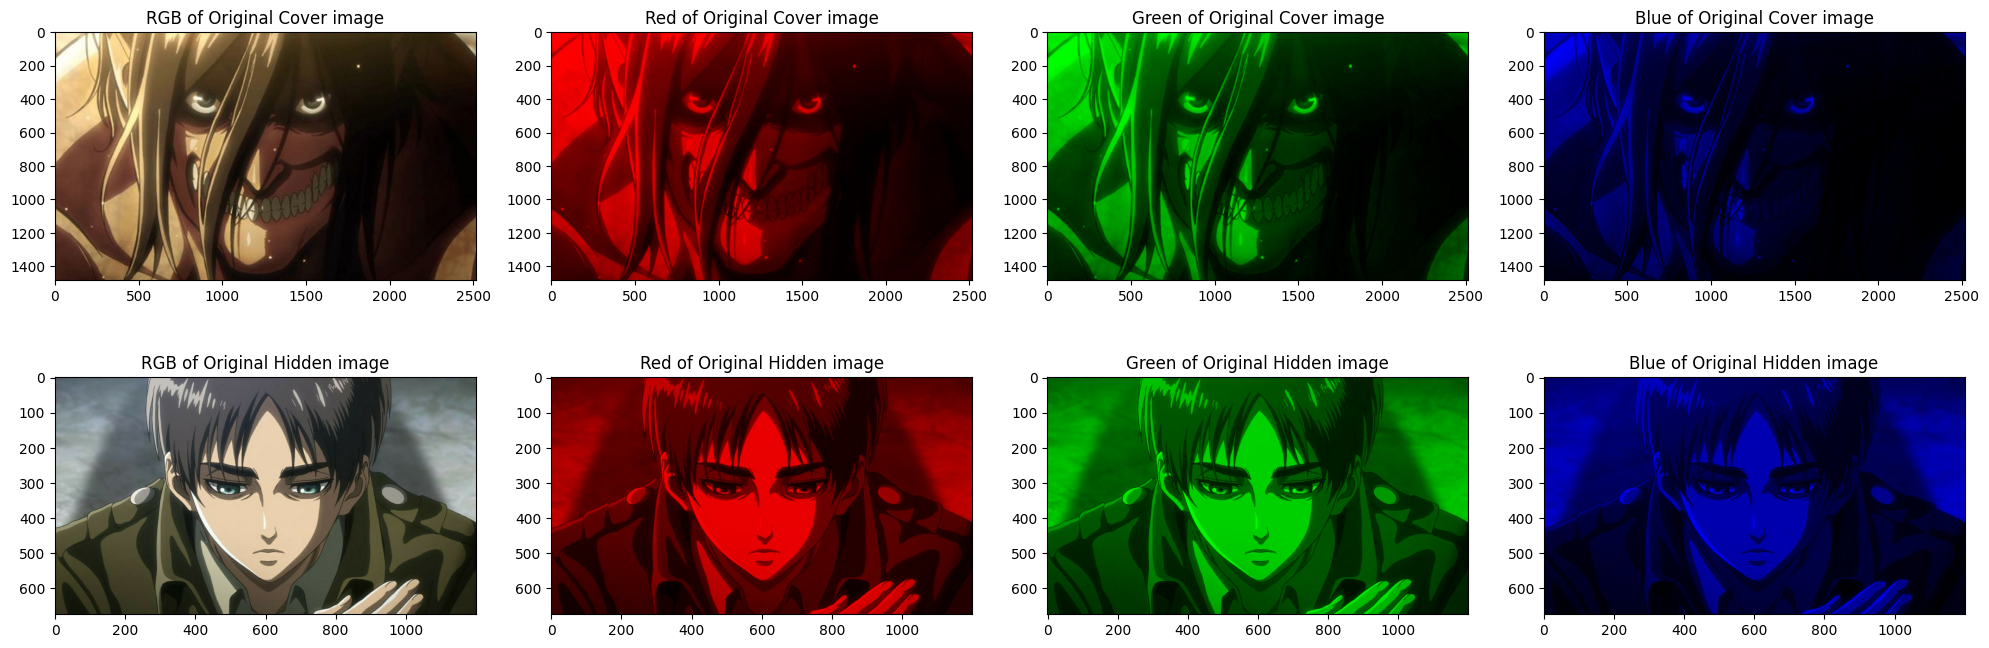

In [13]:
#@title Take a look at the cover and hidden image

sg.plot_original()

In [14]:
#@title Let's encode our first steganograph!

sg.encode()
sg

Steganograph:
ispng: False
original_cover_image: (1480, 2516, 3) uint8
original_hidden_image: (675, 1200, 3) uint8
left_half_bits_hidden_image: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
unmerged_left_half_bits_cover_image: None
unmerged_left_half_bits_hidden_image: None
reconstructed_cover_image: None
reconstructed_hidden_image: None

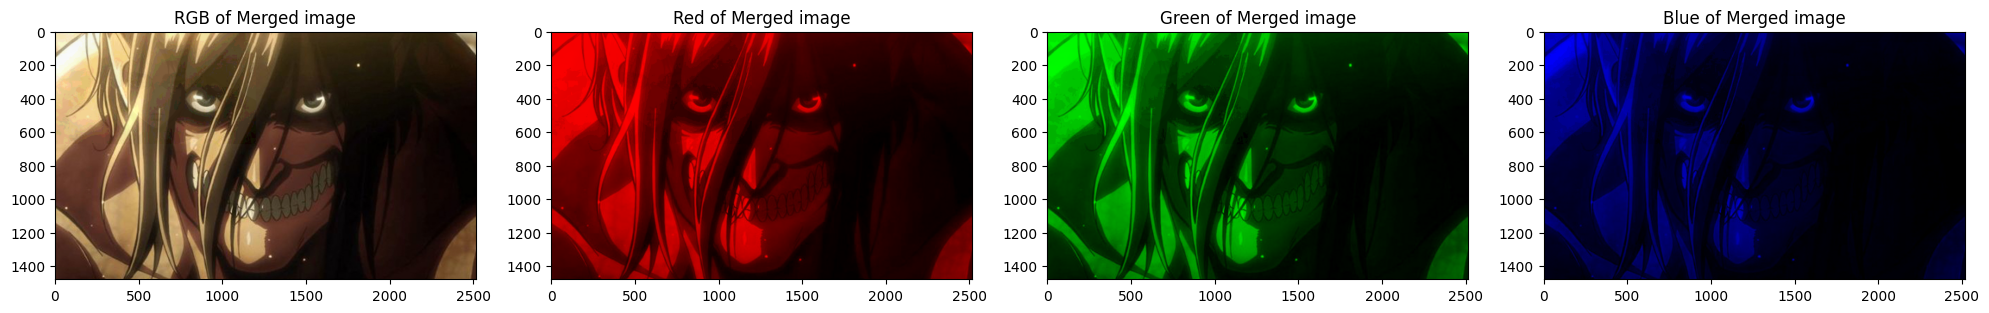

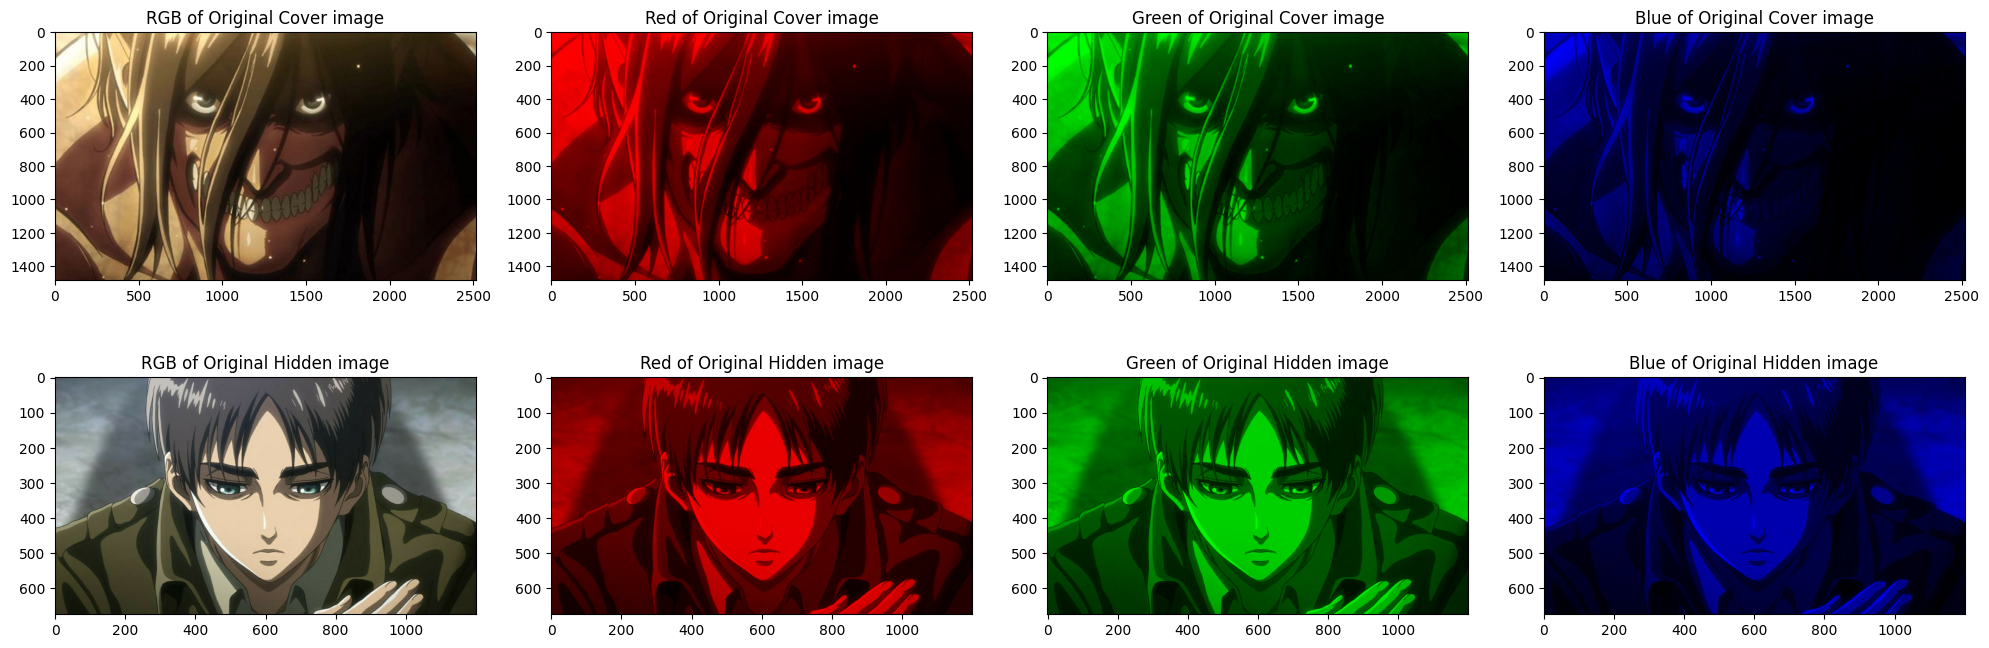

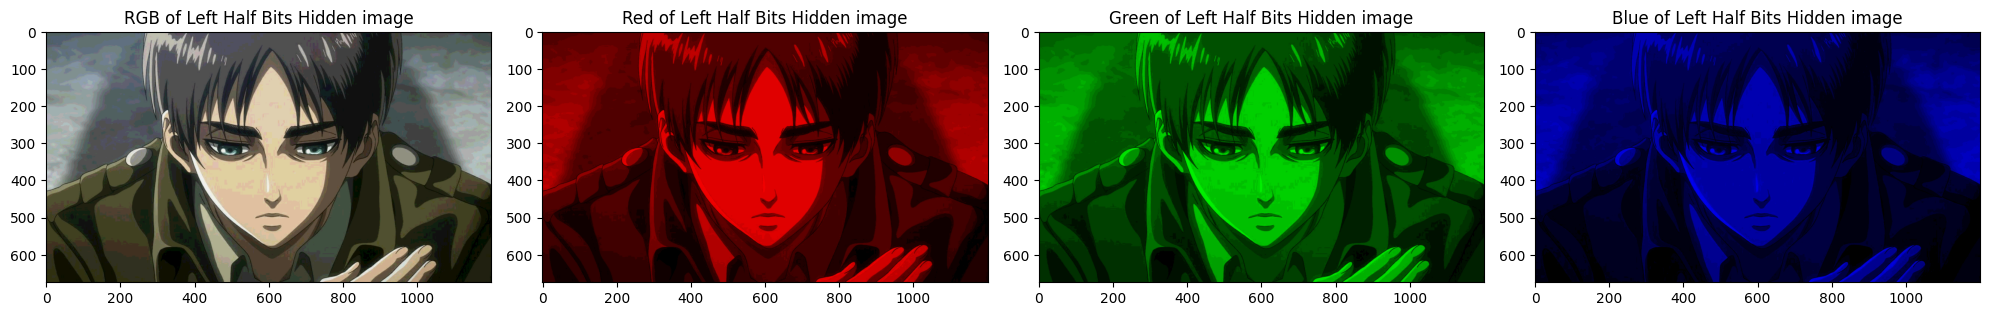

In [15]:
#@title Comparing the merged, original and left half bits hidden image visually

sg.plot_merged_image()
sg.plot_original()
sg.plot_left_half_bits()

In [16]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [17]:
#@markdown Choose which image to save

opt = "3" #@param [0, 1, 2, 3]
sg.save_image(int(opt))

In [18]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.is_two_images_identical.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [19]:
#@title Choose what option to compare after encode {run: 'auto'}

opt = "9" #@param [3, 9]
check, rmse, mae = sg.is_two_images_identical(int(opt))
print(f'Are they equal? {check}\nRMSE\t: {rmse}\nMAE\t: {mae}')

Are they equal? False
RMSE	: 8.868079206151936
MAE	: 7.579809053497942


In [20]:
#@title Let's decode our steganograph

sg.decode()
sg

Steganograph:
ispng: False
original_cover_image: (1480, 2516, 3) uint8
original_hidden_image: (675, 1200, 3) uint8
left_half_bits_hidden_image: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
unmerged_left_half_bits_cover_image: (1480, 2516, 3) uint8
unmerged_left_half_bits_hidden_image: (675, 1200, 3) uint8
reconstructed_cover_image: None
reconstructed_hidden_image: None

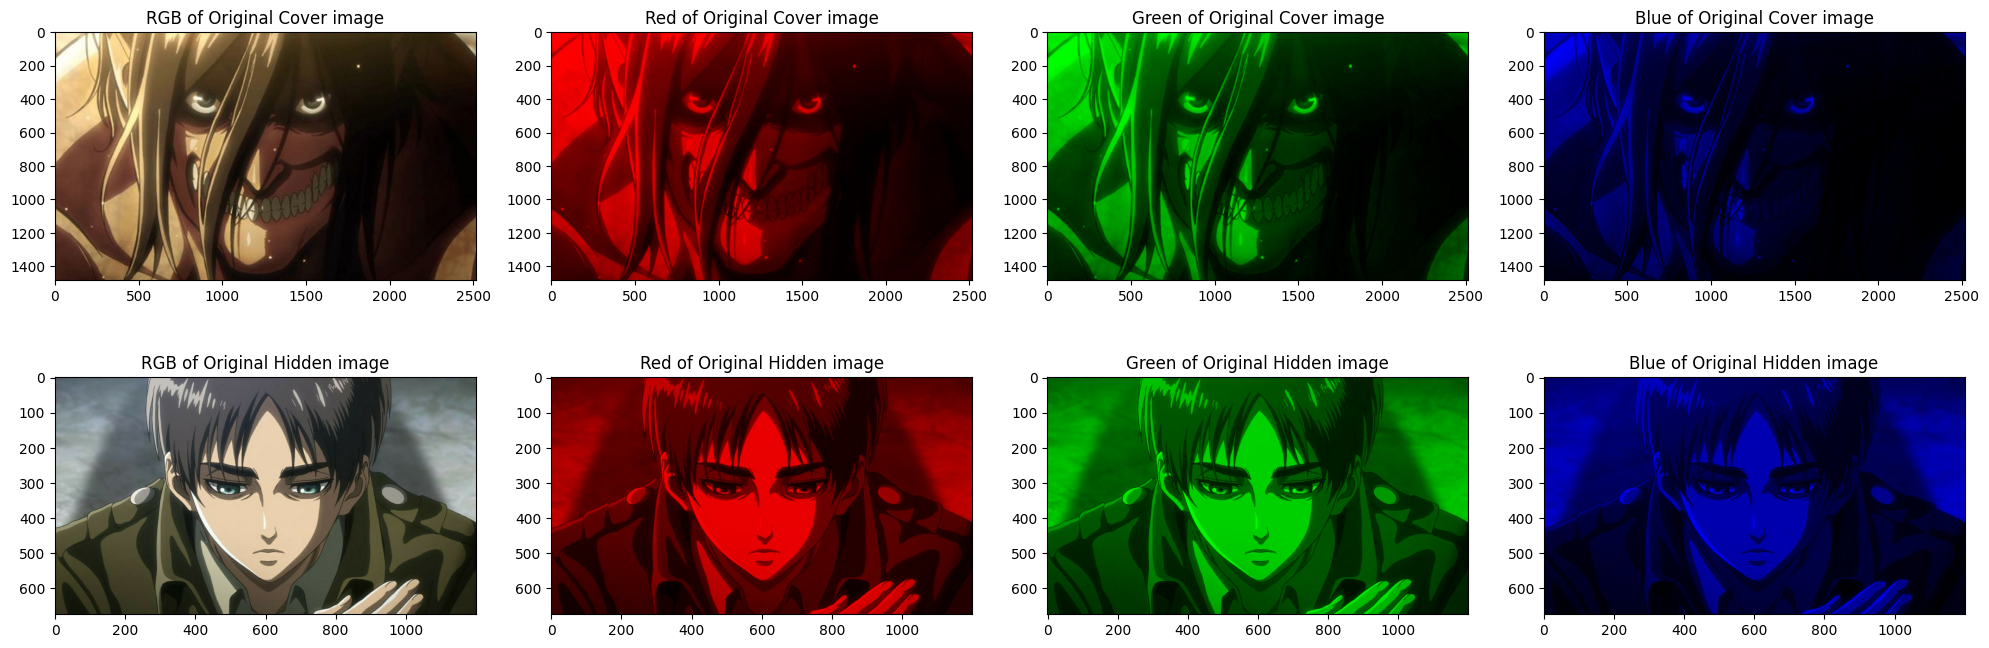

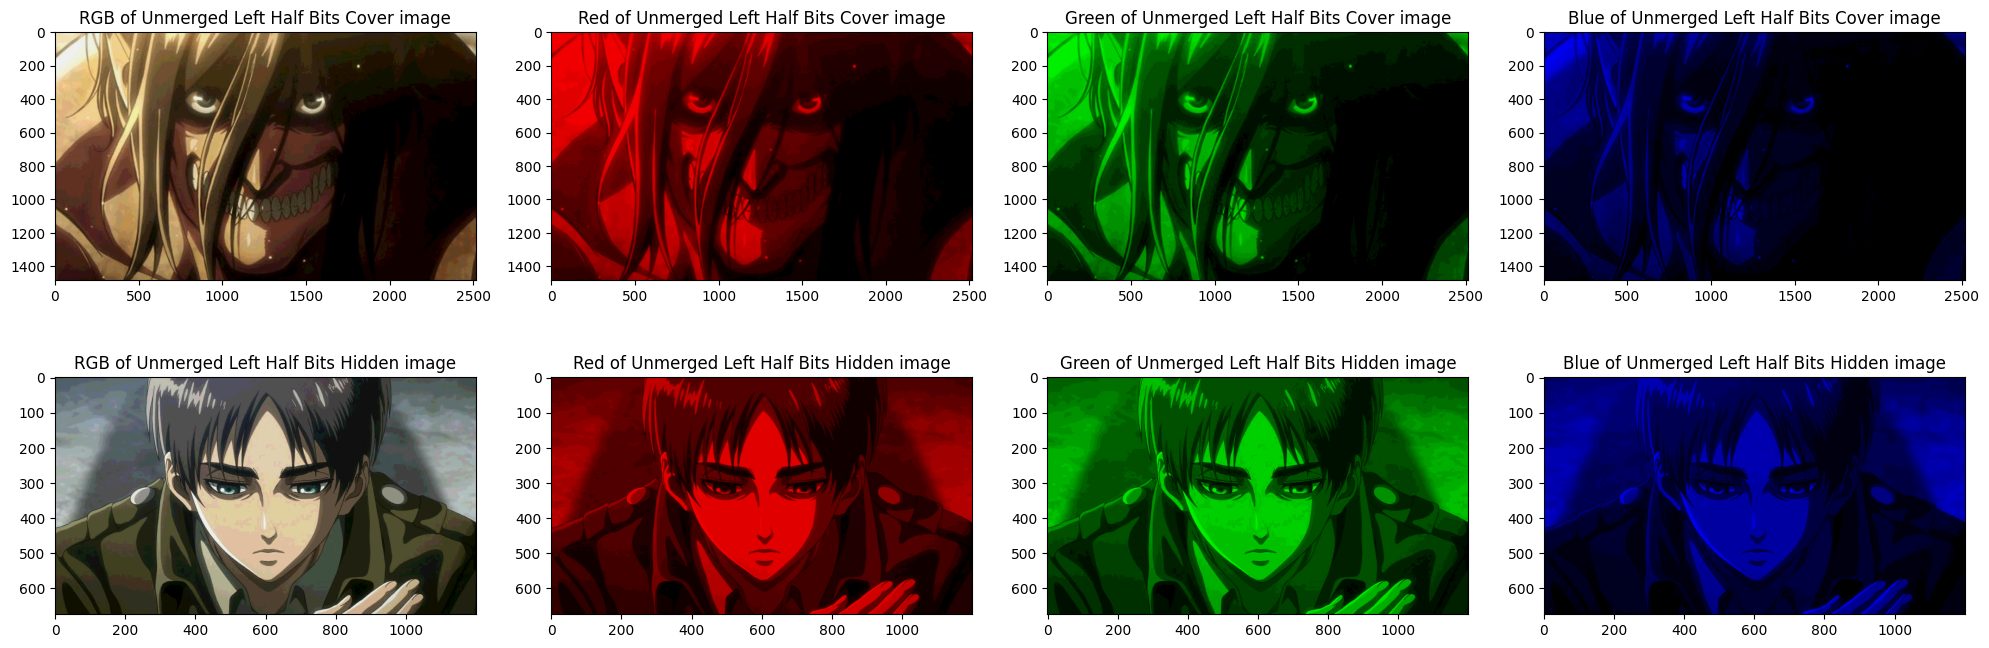

In [21]:
#@title Comparing original and unmerged left half bits images visually

sg.plot_original()
sg.plot_unmerged_left_half_bits()

In [22]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [23]:
#@markdown Choose which image to save

opt = "4" #@param [0, 1, 2, 3, 4, 5]
sg.save_image(int(opt))

In [24]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.is_two_images_identical.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [25]:
#@title Choose what option to compare after decode {run: 'auto'}

opt = "10" #@param [0, 3, 4, 6, 9, 10]
check, rmse, mae = sg.is_two_images_identical(int(opt))
print(f'Are they equal? {check}\nRMSE\t: {rmse}\nMAE\t: {mae}')

Are they equal? True
RMSE	: 0.0
MAE	: 0.0


In [26]:
#@title Let's try to reconstruct our images (right half bits manipulation)

sg.reconstruct()
sg

Steganograph:
ispng: False
original_cover_image: (1480, 2516, 3) uint8
original_hidden_image: (675, 1200, 3) uint8
left_half_bits_hidden_image: (675, 1200, 3) uint8
merged_image: (1480, 2516, 3) uint8
unmerged_left_half_bits_cover_image: (1480, 2516, 3) uint8
unmerged_left_half_bits_hidden_image: (675, 1200, 3) uint8
reconstructed_cover_image: (1480, 2516, 3) uint8
reconstructed_hidden_image: (675, 1200, 3) uint8

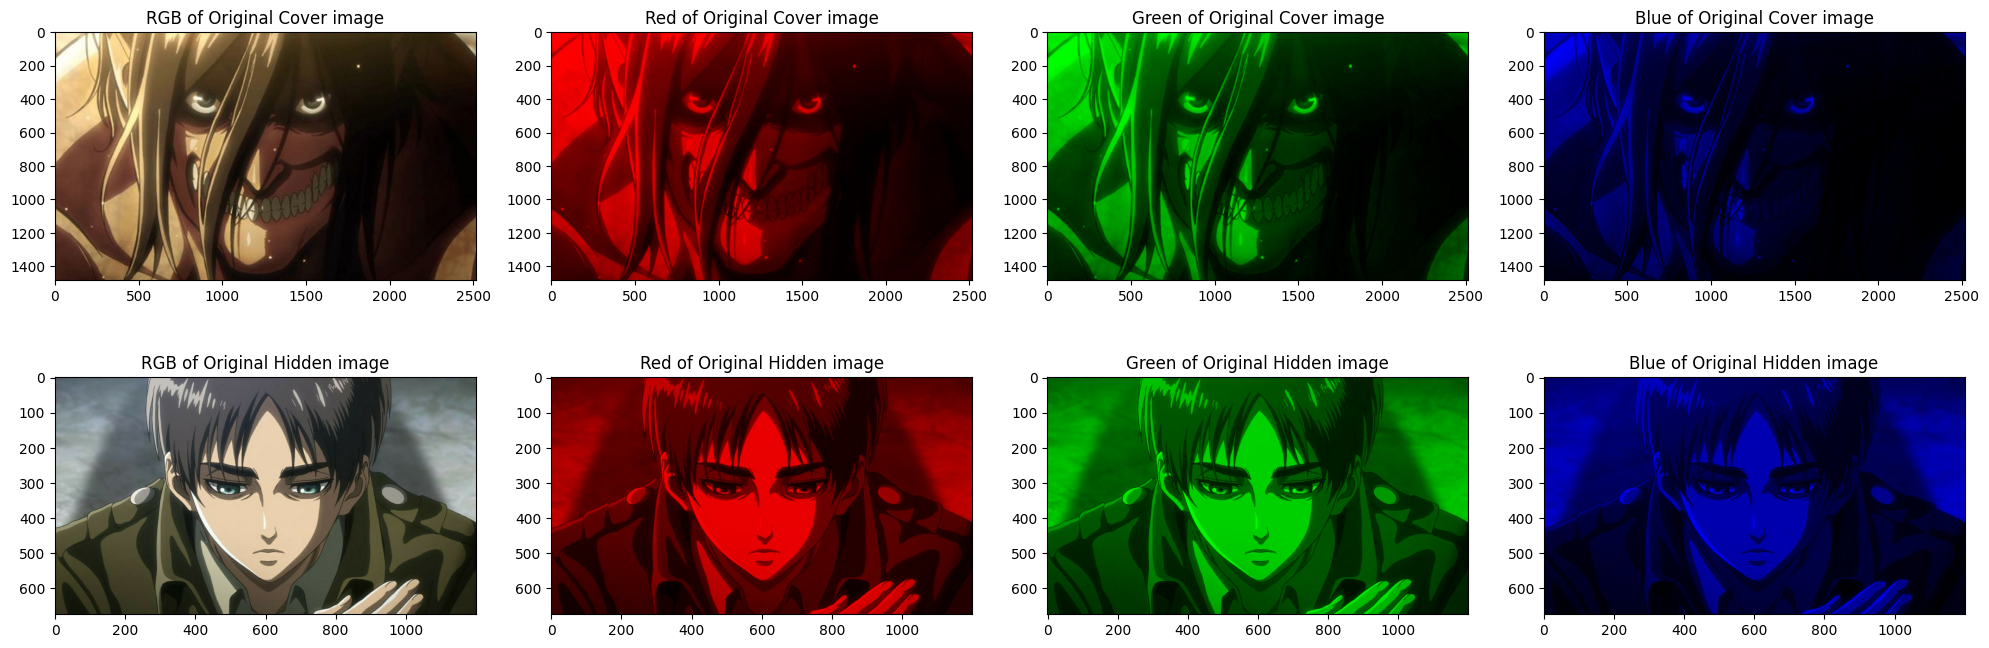

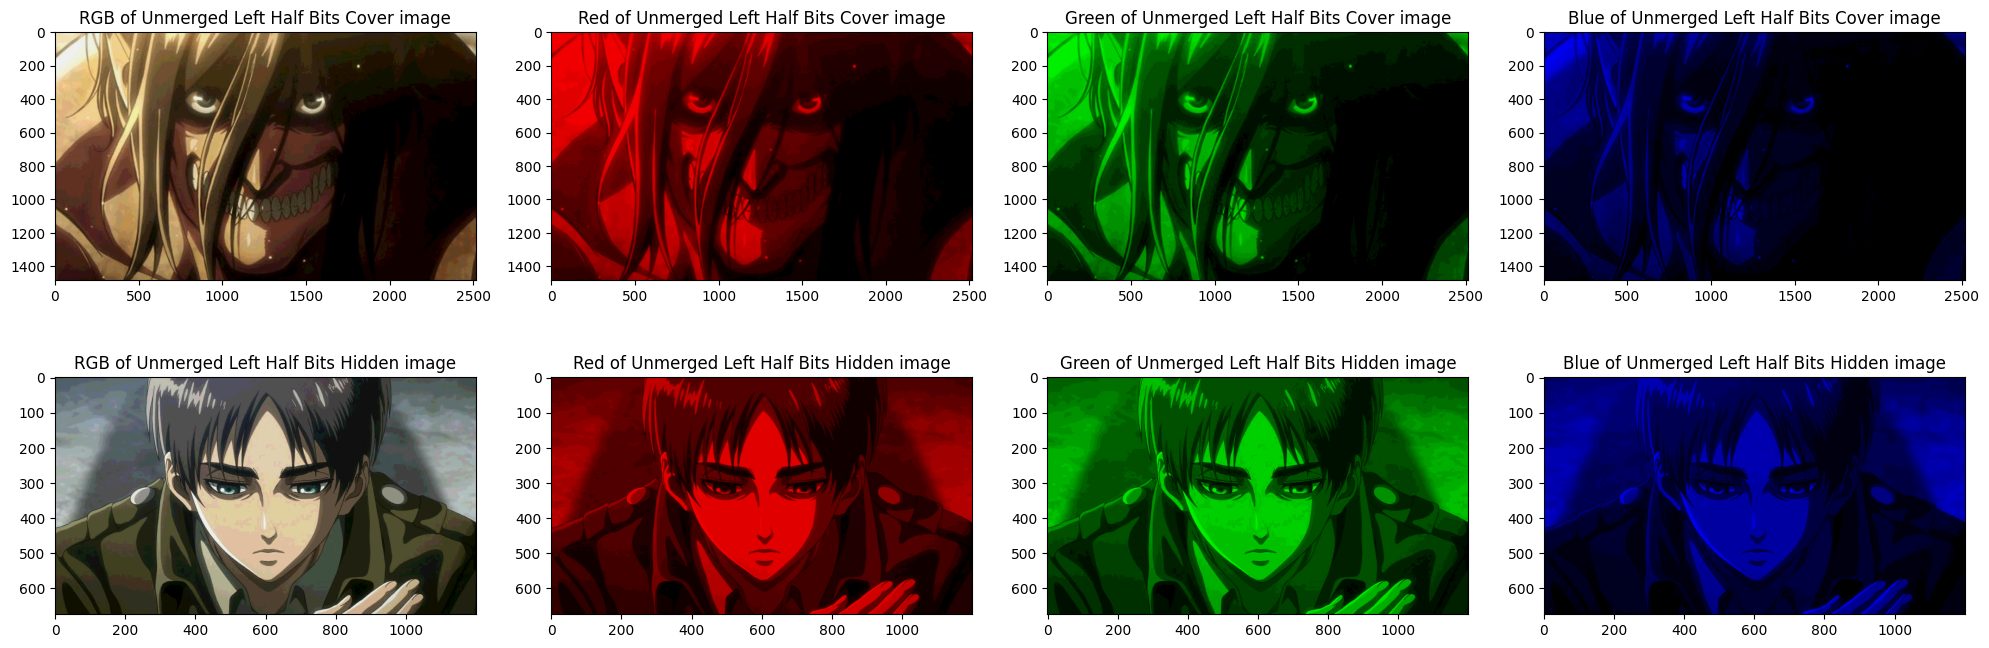

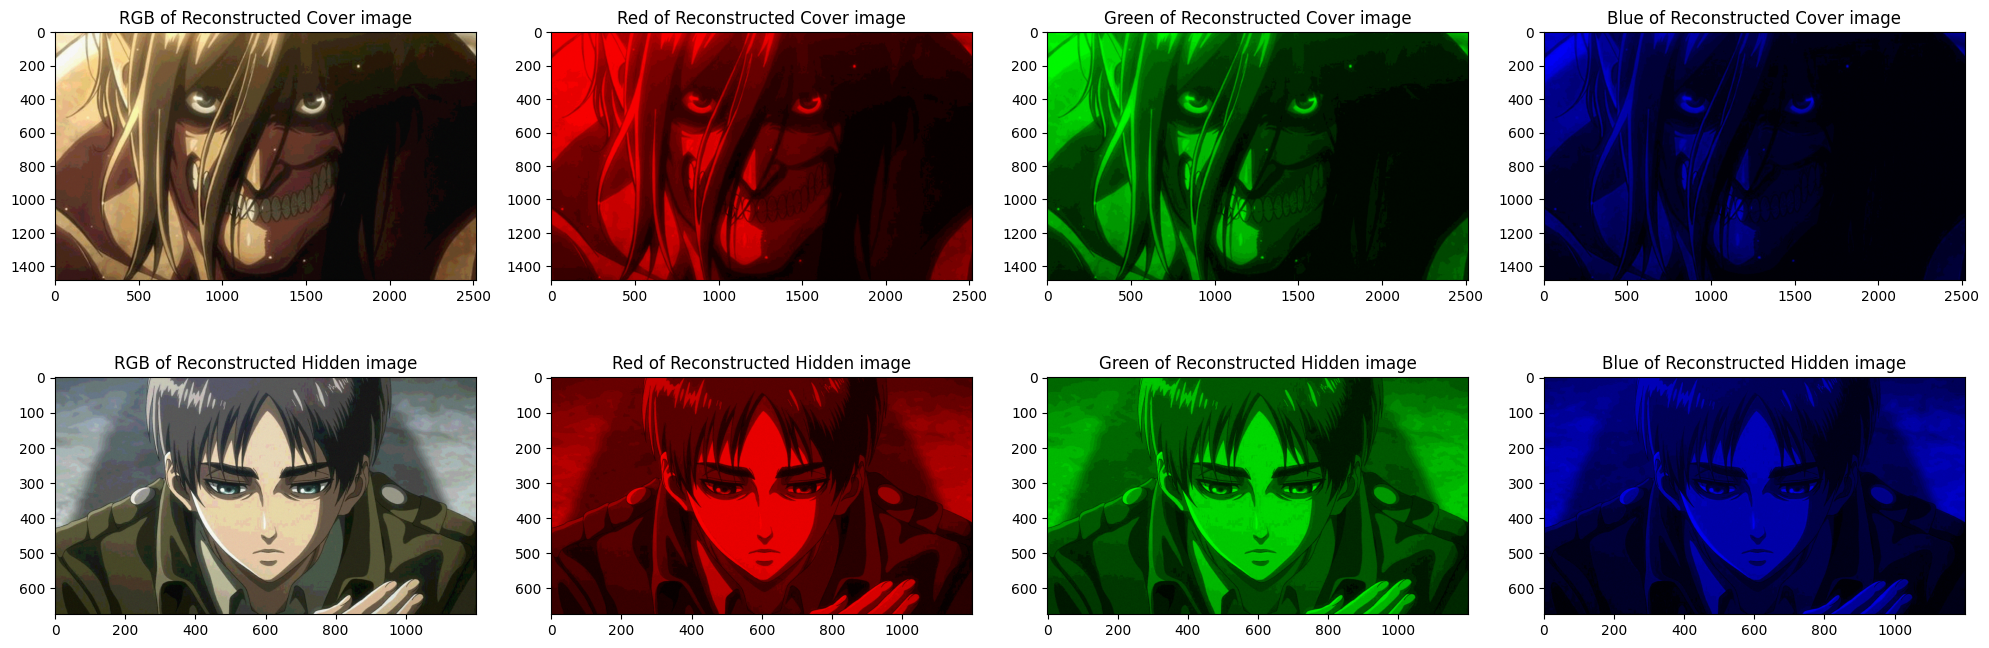

In [27]:
#@title Comparing original, unmerged left half bits and reconstructed images visually

sg.plot_original()
sg.plot_unmerged_left_half_bits()
sg.plot_recon()

In [28]:
#@markdown Let's save some images

print(sg.save_image.__doc__)


        Save an image from steganograph instance.

        Parameter
        ---------
        opt : int, default 0
            option to choose which image to save is as follows:
            0 : original cover image
            1 : original hidden image
            2 : left half bits hidden image
            3 : merged image
            4 : unmerged left half bits cover image
            5 : unmerged left half bits hidden image
            6 : reconstructed cover image
            7 : reconstructed hidden image
        


In [29]:
#@markdown Choose which image to save

opt = "6" #@param [0, 1, 2, 3, 4, 5, 6, 7]
sg.save_image(int(opt))

In [30]:
#@markdown Check whether the images we've seen are as equal as we expected

print(sg.is_two_images_identical.__doc__)


        Check whether certain image are as equal as other image.
        
        Parameter
        ---------
        opt : int, default 0
            option to check between two images are as follows:
            0 : original cover image <-> unmerged left half bits cover image
            1 : original cover image <-> reconstructed cover image
            2 : unmerged left half bits cover image <-> reconstructed cover image
            3 : merged image <-> original cover image
            4 : merged image <-> unmerged left half bits cover image
            5 : merged image <-> reconstructed cover image
            6 : original hidden image <-> unmerged left half bits hidden image
            7 : original hidden image <-> reconstructed hidden image
            8 : unmerged left half bits hidden image <-> reconstructed hidden image
            9 : left half bits hidden image <-> original hidden image
            10 : left half bits hidden image <-> unmerged left half bits hidden image
 

In [31]:
#@title Choose what option to compare after decode {run: 'auto'}

opt = "5" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
check, rmse, mae = sg.is_two_images_identical(int(opt))
print(f'Are they equal? {check}\nRMSE\t: {rmse}\nMAE\t: {mae}')

Are they equal? False
RMSE	: 6.430331088823222
MAE	: 108.76716841046134
